In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os, torch
import torch.nn as nn
import torch.optim as optim
import itertools

from tqdm import tqdm
from ista_unet import *
from ista_unet.models import ista_unet
from ista_unet.evaluate import *
from ista_unet.load_jin_ellipses_dataset import get_dataloaders_ellipses
from ista_unet.utils import crop_center_2d
from os import  path
from dival.util.plot import plot_images
import dival
from ista_unet import model_save_dir

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loaders_bs1 = get_dataloaders_ellipses(batch_size=1, distributed_bool = False, num_workers = 0)

In [2]:
guid = '7e7403b2-41a4-40f1-87c0-551c986fef52'
    
model, config_dict = load_ista_unet_model(guid = guid, 
                             dataset = 'ellipses', 
                             return_config_dict = True)
model.to(device);

### SNR

In [3]:
# psnrs = []
snrs = []
print('Evaluating model')
with torch.no_grad():
    for obs, gt in loaders_bs1['test']:
        reco = model(obs.to(device)).cpu()
        snrs.append( SNRab(reco, gt)[0] )

print('mean snr on test set: {:f}'.format(np.mean(snrs)))

Evaluating model
mean snr on test set: 27.022722


## Visualization

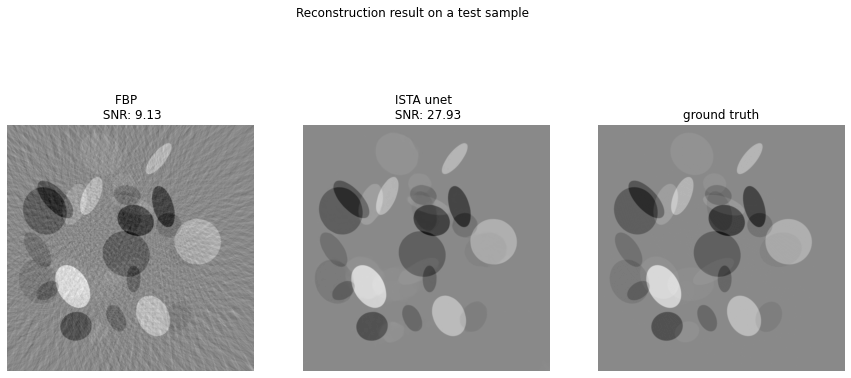

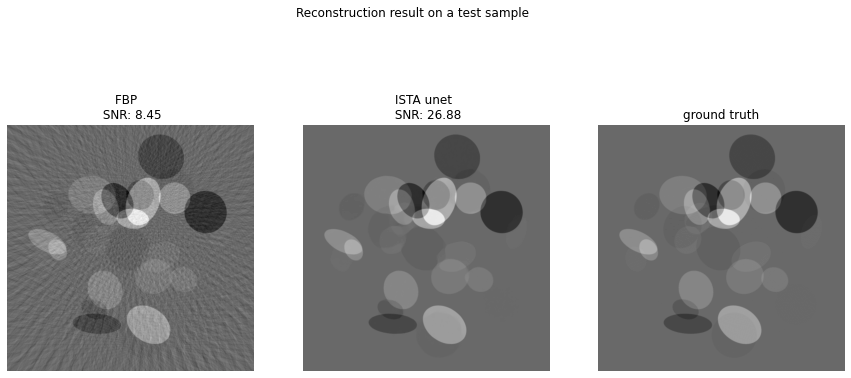

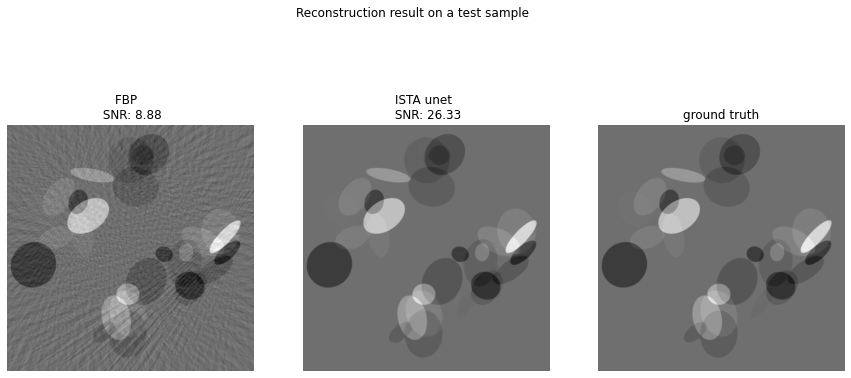

In [7]:
for sample_at in range(3):
    obs, gt = next(itertools.islice(loaders_bs1['test'], sample_at, None))
    
    with torch.no_grad():
        recon = model(obs.to(device)).cpu().detach()#.numpy()
    
    obs_snr = SNRab(obs, gt)[0]
    ista_unet_snr = SNRab(recon, gt)[0]

    _, ax = plot_images([obs.cpu()[0,0], recon[0,0], gt.cpu()[0,0]], fig_size=(15, 7), cbar = 'none')
    ax[0].set_title('FBP  \n SNR: {:.2f}'.format(obs_snr) )
    ax[0].axis('off')
    ax[1].set_title('ISTA unet \n SNR: {:.2f}'.format(ista_unet_snr))
    ax[1].axis('off')
    ax[2].set_title('ground truth')
    ax[2].axis('off')

    ax[1].figure.suptitle('Reconstruction result on a test sample')